<a href="https://colab.research.google.com/github/Raf-Schwalbe/movie_review_classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction - what do we want to achieve?
Purpose of the analysis is to build a classification model that is able to classify whether review was positive or negative.

We start we setting workspace and EDA - after understading the data next steps will be determined


Let start with setting working dir and importing some libraries
 

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/DataScience/Project/movie_review_classification')
%cd /content/drive/MyDrive/DataScience/Project/movie_review_classification

In [ ]:
#_________________________________________________import libraries______________________________________________________

import io, os, sys, types, time, datetime, math, random, requests, subprocess, tempfile

# Data Manipulation
import numpy as np
import pandas as pd
import re

# Visualization
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly


#Modelling
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif

#Interpretation
from sklearn.model_selection import train_test_split
from sklearn import metrics, decomposition, manifold
import ast
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn import inspection
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix

# Exploratory Data Analysis



First look at the data

In [ ]:
raw = pd.read_csv('data.csv', delimiter=";")

In [ ]:

#_________________________________________________EDA___________________________________________________________________
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 51 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   worst           25000 non-null  int64
 1   waste           25000 non-null  int64
 2   awful           25000 non-null  int64
 3   poorly          25000 non-null  int64
 4   excellent       25000 non-null  int64
 5   dull            25000 non-null  int64
 6   boring          25000 non-null  int64
 7   perfect         25000 non-null  int64
 8   disappointment  25000 non-null  int64
 9   mess            25000 non-null  int64
 10  fails           25000 non-null  int64
 11  disappointing   25000 non-null  int64
 12  terrible        25000 non-null  int64
 13  laughable       25000 non-null  int64
 14  poor            25000 non-null  int64
 15  amazing         25000 non-null  int64
 16  annoying        25000 non-null  int64
 17  great           25000 non-null  int64
 18  bad             25000 non-


1.   there is 25 000 observations 
2.   we have 50 and independent and one independent variable
3.   the variables are mostly adjectives and few verbs
4.   there are no missings

## Variation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To sile

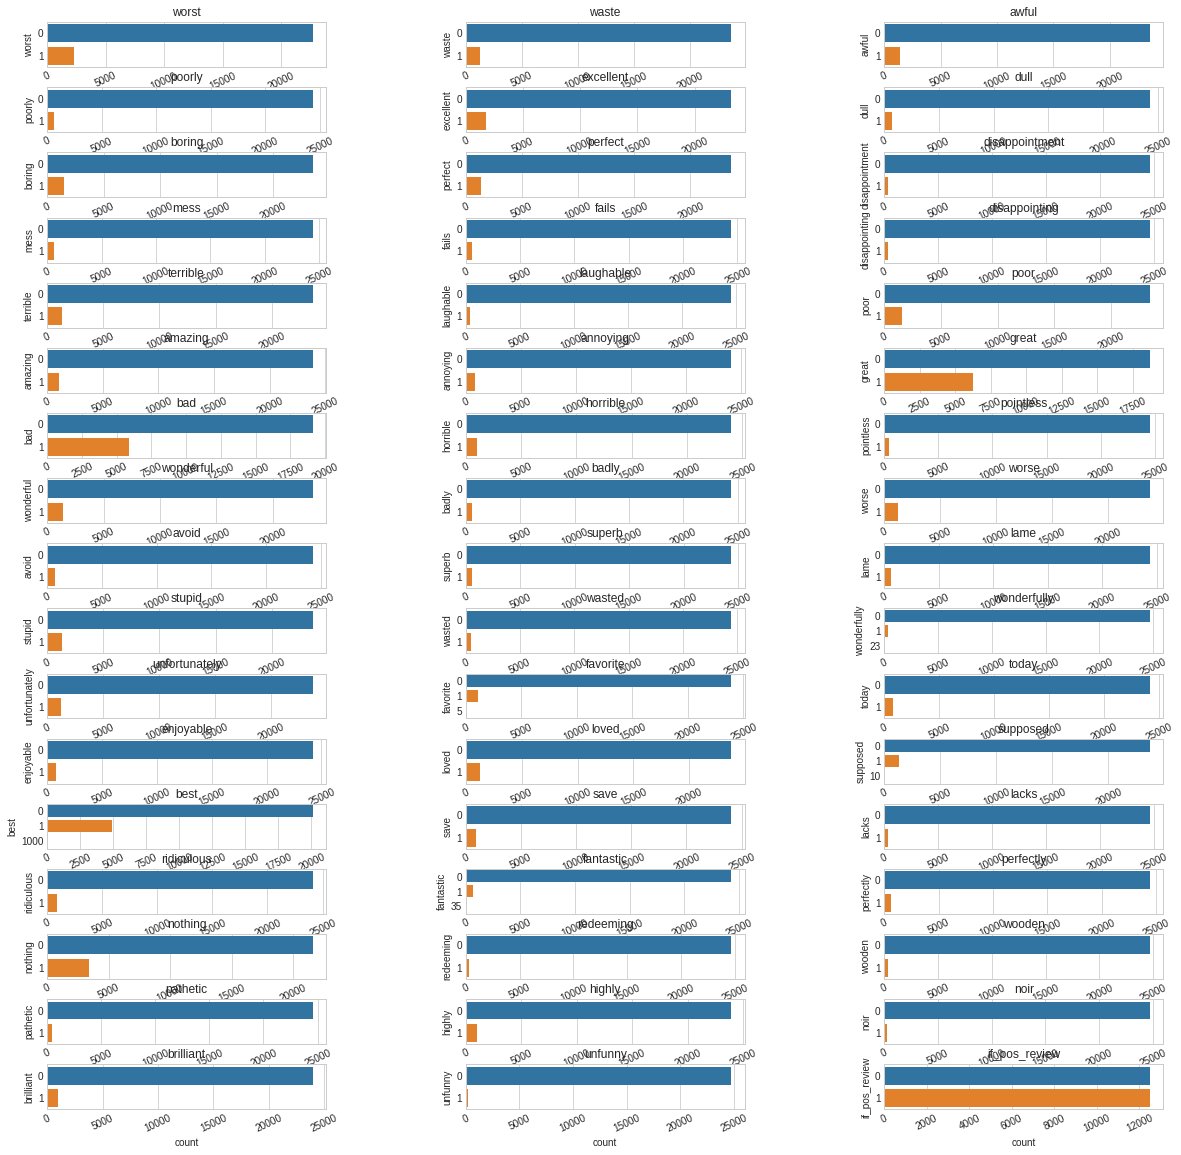

In [ ]:
# Let’s plot the distribution of each feature
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(raw.astype(object), cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

Independent variables are unbalanced - there are mostly 0

Dependent variables is balanced - there are same number of positive and negative reviews.

### Outliers

In 5 variables are not only 0, 1 values

In [ ]:
for col in raw:
  if raw[col].isin([0,1]).all() == False:
    print(col, raw[col].nunique(), raw[col].unique(), raw.groupby([col])[col].count())

wonderfully 3 [ 0  1 23] wonderfully
0     24692
1       307
23        1
Name: wonderfully, dtype: int64
favorite 3 [0 1 5] favorite
0    23915
1     1084
5        1
Name: favorite, dtype: int64
supposed 3 [ 0  1 10] supposed
0     23694
1      1305
10        1
Name: supposed, dtype: int64
best 3 [   0    1 1000] best
0       20113
1        4886
1000        1
Name: best, dtype: int64
fantastic 3 [ 0  1 35] fantastic
0     24297
1       702
35        1
Name: fantastic, dtype: int64


In all cases only one case were noticed so 3 options emerged: 
1. use imputation method or
2. just notice that values of other variables of this observation unambiguously point that it should be 1 instead of 0. 
3. The third option is to drop the observation.

In 4 cases the option 2 was selected. In case of favorite it observation was not unambigous so it was dropped.

In [ ]:
raw[raw.isin([0,1]).all(axis=1) == False].T

,7091,10866,10935,16822,16955
worst,0,0,0,0,0
waste,0,0,0,0,0
awful,0,0,0,0,0
poorly,0,0,0,0,0
excellent,0,0,0,0,0
dull,0,0,0,0,0
boring,0,0,0,0,0
perfect,0,0,0,0,0
disappointment,0,0,0,0,0
mess,0,0,0,0,0


In [ ]:
raw['best'] = raw.apply(lambda x : 1 if x['best'] == 1000 else x['best'], axis = 1)
raw['wonderfully'] = raw.apply(lambda x : 1 if x['wonderfully'] == 23 else x['wonderfully'], axis = 1)
raw['fantastic'] = raw.apply(lambda x : 1 if x['fantastic'] == 35 else x['fantastic'], axis = 1)
raw['supposed'] = raw.apply(lambda x : 0 if x['supposed'] == 10 else x['supposed'], axis = 1)

In [ ]:
raw.shape

(24999, 51)

In [ ]:
raw.drop(raw[raw.favorite == 5].index, inplace=True)

Check again if there are only 0 and 1

In [ ]:
for col in raw:
  if raw[col].isin([0,1]).all() == False:
    print(col, raw[col].nunique(), raw[col].unique(), raw.groupby([col])[col].count())

### Only 0 observations
There are more thab 3200  observations were are only 0 will not be useful for clasification.
Remove them

In [ ]:
raw.shape

(21752, 52)

In [ ]:
raw["col_sum"] = raw.loc[:, raw.columns != "if_pos_review"].sum(axis=1)
raw.groupby(['col_sum']).count()
raw[['col_sum']].mean()
raw.drop(raw[raw.col_sum == 0].index, inplace=True)

In [ ]:
raw = raw.drop(['col_sum'], axis=1)

Save a clean, ready for modelling dataset

In [ ]:
raw.to_csv('cleaned_dataset.csv')

## Covariation

One can expect that presence of a variables (words) with positive sentiment is positively covariated with other variables with positive sentiment and negatively covariated with variables with negative minning.

Second expectation is a positive correlation of positive review with words with poisitive meaning


In [ ]:
raw = pd.read_csv('cleaned_dataset.csv', delimiter=";")

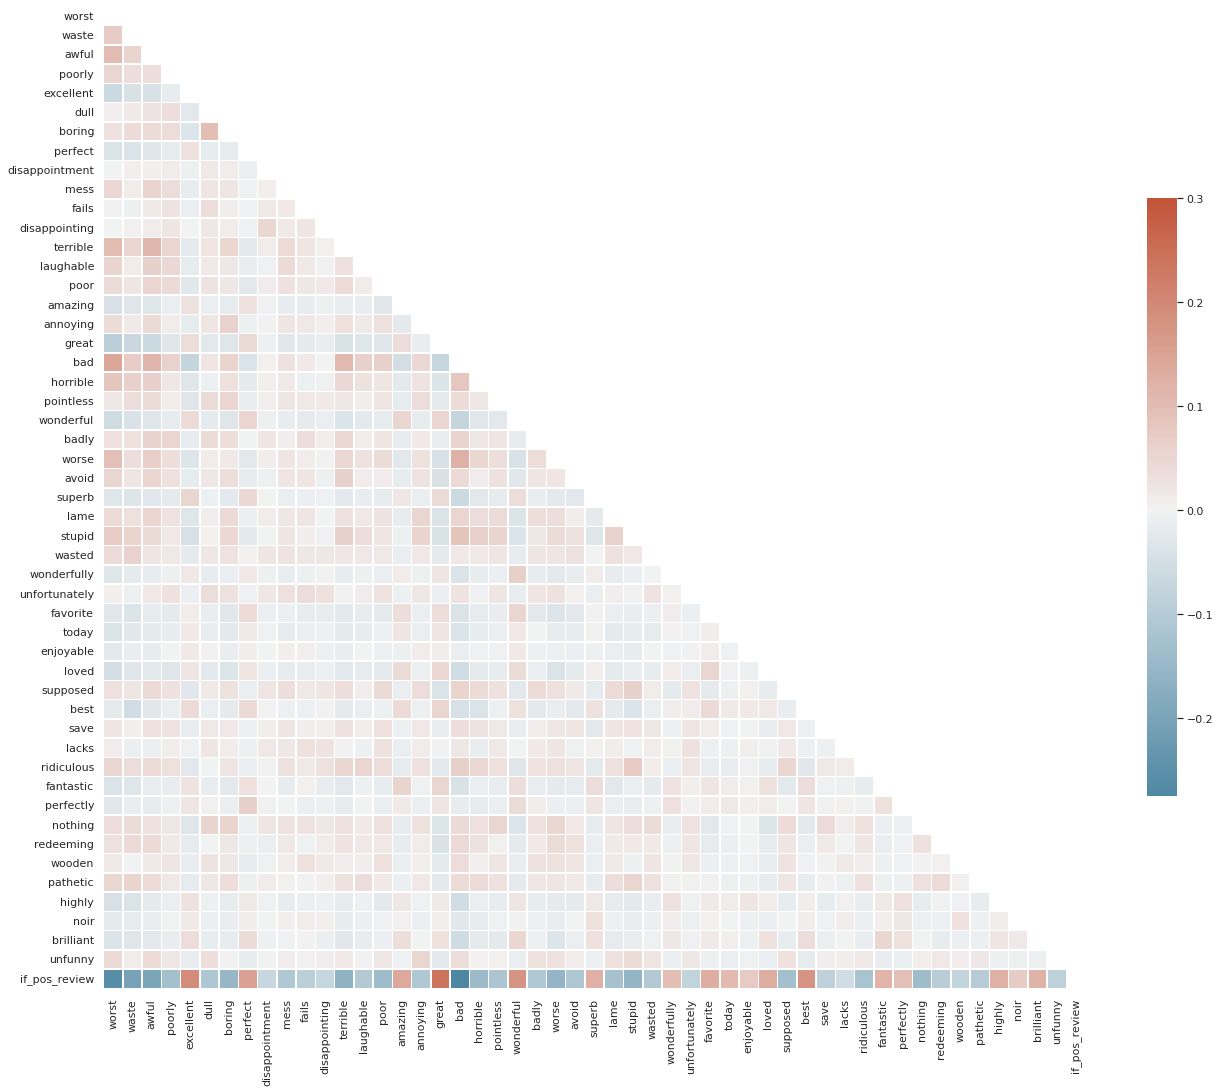

In [ ]:
sns.set_theme(style="white")
# Compute the correlation matrix. There is discussion whether pearson correlation is appropriate for binary data. I assume that for the EDA purposes the differences are acceptable
corr = raw.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 22))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In general, dependent variable is stronger correlated with indepedent variables, than independent variables among each other. 

#Modelling

Next step is modelling.
The aim is to find best model - feature selection combination.

Features will be selected with: 

1.   filter feature selection - SelectKBest (with mutual info classif) or
2.   RFCV. Estimators used during RFCV are as follows: Logistic Regression, Decision Tree, Random Forest, Gradient Boosting

After feature selection following models will be built:
 1. Logistic Regression, 
 2. Decision Tree, 
 3. Random Forest, 
 4. Gradient Boosting
 5. Support vector classifier

The best combination will be selected with cross validation with accuracy as a criterium.

For best combination the hyperparameter tuning will be conducted.
It will be made with grid search and the best hyperparameters will be selected with cross validation with accuracu as a criterium

Below we declare variables and split dataset into X and y (dependent variable)
We do not use train, test and validation dataset instead cross validation is used
Note that there are a commented lines where only very small dataset is selected in order to check if script runs without any errors. 


In [ ]:
########################################################################################################################
"""Models - data import and variables preparation"""


# import data
X = raw.loc[:, raw.columns != 'if_pos_review']
y = raw['if_pos_review']

#Here we take very small, sample of the dataset in order to chceck whether the code works.
#After the check comment the below 3 lines and run the code again on whole dataset
#X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, 0:19], y, train_size=0.01, random_state=5)
#X = X_train
#y = y_train

#definition of cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#models we check
models = []
models.append(('SVC', SVC())) #linear
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier())) #treebased
models.append(('RF', RandomForestClassifier())) #treebased
models.append(('GB', GradientBoostingClassifier())) #treebased




##Models - filter model selection - SelectKBest

SelectKBest needs hyperparameter - select_k - how many variables to select. We check all options (from one to number of variables) in grid search.  
Note that a few model features are saved in order to reatain information even if problems with next sections occur.


In [ ]:
# it runs 35min

########################################################################################################################
#"""Models - filter model selection - SelectKBest""" clean dataset

#variables to store the modelling results
names = []
scores = []
name_e = []
n_feat = []
model_name = []

n_iter = 10

fs = SelectKBest(score_func=mutual_info_classif)

for name_m, model in models:
	pipeline = Pipeline(steps=[
		('select', SelectKBest(score_func=mutual_info_classif)),
		('classify', model)])
	grid = dict()
	grid['select__k'] = [i + 1 for i in range(X.shape[1])]
	cv_pipeline = RandomizedSearchCV(estimator=pipeline, param_distributions=grid, n_iter = n_iter)
	results = cv_pipeline.fit(X=X, y=y)
	final_pipeline = cv_pipeline.best_estimator_
	final_classifier = final_pipeline.named_steps['classify']
	select_indices = final_pipeline.named_steps['select'].get_support(indices=True)
	feature_names = [X.columns[i] for i in select_indices]
	print('Best Mean Accuracy: %.3f' % cv_pipeline.best_score_)
	names.append(name_m)
	scores.append(results.best_score_)
	name_e.append(fs)
	n_feat.append(feature_names)
	model_name.append(model)
 
kf_cross_val = pd.DataFrame({'Name_m': names, 'Name_e': name_e, 'Score': scores, 'feat' : n_feat, 'model': model_name})
kf_cross_val.to_csv('final_model_kbest_clean data set')

Best Mean Accuracy: 0.815
Best Mean Accuracy: 0.814
Best Mean Accuracy: 0.788
Best Mean Accuracy: 0.806
Best Mean Accuracy: 0.816


In [ ]:
kf_cross_val

,Name_m,Name_e,Score,feat,model
0,SVC,SelectKBest(score_func=<function mutual_info_c...,0.814637,"[worst, waste, awful, poorly, excellent, dull,...",SVC()
1,LR,SelectKBest(score_func=<function mutual_info_c...,0.814408,"[worst, waste, awful, poorly, excellent, dull,...",LogisticRegression()
2,DT,SelectKBest(score_func=<function mutual_info_c...,0.787927,"[worst, waste, awful, poorly, excellent, dull,...",DecisionTreeClassifier()
3,RF,SelectKBest(score_func=<function mutual_info_c...,0.806178,"[worst, waste, awful, poorly, excellent, dull,...",RandomForestClassifier()
4,GB,SelectKBest(score_func=<function mutual_info_c...,0.816201,"[worst, waste, awful, poorly, excellent, dull,...",GradientBoostingClassifier()


In [ ]:
kf_cross_val.feat.str.len()

0    47
1    42
2    46
3    48
4    50
Name: feat, dtype: int64

The accuracy of the models is from 79% (decision tree) to 82% (logistic regression)
The question is about number of variables selected - almost all variables were selected.

If better model will not be found there will be need to address high number of variables.

In early version of the notebook the number of variables hyperparameter was searched with grid search (like in cell below).
The mean accuracy was about 82% so around 0,5-1 pp higher than with random search.
However it multiplied time of execution significantly (to almost 4 hours), therefore finally random search was used.

In [ ]:
#DO NOT RUN

########################################################################################################################
#"""Models - filter model selection - SelectKBest"""

#variables to store the modelling results
names = []
scores = []
name_e = []
n_feat = []
model_name = []

fs = SelectKBest(score_func=mutual_info_classif)

for name_m, model in models:
	pipeline = Pipeline(steps=[
		('select', SelectKBest(score_func=mutual_info_classif)),
		('classify', model)])
	grid = dict()
	grid['select__k'] = [i + 1 for i in range(X.shape[1])]
	cv_pipeline = GridSearchCV(estimator=pipeline, param_grid=grid)
	results = cv_pipeline.fit(X=X, y=y)
	final_pipeline = cv_pipeline.best_estimator_
	final_classifier = final_pipeline.named_steps['classify']
	select_indices = final_pipeline.named_steps['select'].get_support(indices=True)
	feature_names = [X.columns[i] for i in select_indices]
	print('Best Mean Accuracy: %.3f' % cv_pipeline.best_score_)
	names.append(name_m)
	scores.append(results.best_score_)
	name_e.append(fs)
	n_feat.append(feature_names)
	model_name.append(model)
 
kf_cross_val = pd.DataFrame({'Name_m': names, 'Name_e': name_e, 'Score': scores, 'feat' : n_feat, 'model': model_name})
kf_cross_val.to_csv('final_model_kbest')

##Models - RFCV model selection

For every analyzed model the feature selection was made using RFCV. Estimators used in feature selection was Logistic Regression, Descistion Tree, Random Forest and Gradient Boosing Classifier. The hyperparameter minimum features to select was set at 10 based on number of features, number of features selected with select K best method and low level of independent variables correlation. The quality of fit was assesed by accuracy.

Next, model were trained with the set of variables selected by the best estimator. The goodness of fit again was assess with mean (for cross validation) accuracy.

The results, best feature selection estimator and set of selected features were save.


In [ ]:
#it runs 60 min

########################################################################################################################
"""Models - RFCV model selection"""
#variables to store the modelling results
names = []
scores = []
name_e = []
n_feat = []
model_name = []

estimators = []
estimators.append(('LR', LogisticRegression()))
estimators.append(('DT', DecisionTreeClassifier()))
estimators.append(('RF', RandomForestClassifier()))
estimators.append(('GB', GradientBoostingClassifier()))

for name, esti in estimators:
	rfecv = RFECV(estimator=esti, step=1, min_features_to_select=10, cv=10, scoring='accuracy', verbose=0, n_jobs=None)
	rfecv.fit(X, y)
	feature_importance = list(zip(X.columns, rfecv.support_))
	new_features = []
	for key, value in enumerate(feature_importance):
		if (value[1]) == True:
			new_features.append(value[0])
	X_new = X[new_features]
	for name_m, model in models:
		score = cross_val_score(model, X_new, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()
		names.append(name_m)
		scores.append(score)
		name_e.append(name)
		n_feat.append(new_features)
		model_name.append(model)

kf_cross_val_rfcv = pd.DataFrame({'Name_m': names, 'Name_e': name_e, 'Score': scores, 'feat' : n_feat, 'model': model_name})
kf_cross_val_rfcv.to_csv('final_model_rfcv_cleandataset')

In [ ]:
kf_cross_val_rfcv

,Name_m,Name_e,Score,feat,model
0,SVC,LR,0.820354,"[worst, waste, awful, poorly, excellent, dull,...",SVC()
1,LR,LR,0.826300,"[worst, waste, awful, poorly, excellent, dull,...",LogisticRegression()
2,DT,LR,0.787790,"[worst, waste, awful, poorly, excellent, dull,...",DecisionTreeClassifier()
3,RF,LR,0.808278,"[worst, waste, awful, poorly, excellent, dull,...",RandomForestClassifier()
4,GB,LR,0.817503,"[worst, waste, awful, poorly, excellent, dull,...",GradientBoostingClassifier()
5,SVC,DT,0.810240,"[worst, waste, awful, poorly, excellent, dull,...",SVC()
6,LR,DT,0.810500,"[worst, waste, awful, poorly, excellent, dull,...",LogisticRegression()
7,DT,DT,0.789476,"[worst, waste, awful, poorly, excellent, dull,...",DecisionTreeClassifier()
8,RF,DT,0.805106,"[worst, waste, awful, poorly, excellent, dull,...",RandomForestClassifier()
9,GB,DT,0.811803,"[worst, waste, awful, poorly, excellent, dull,...",GradientBoostingClassifier()


In [ ]:
fm = pd.read_csv('final_model_rfcv_cleandataset')
fm.feat.str.count(' ')

0     49
1     49
2     49
3     49
4     49
5     37
6     37
7     37
8     37
9     37
10    48
11    48
12    48
13    48
14    48
15    49
16    49
17    49
18    49
19    49
Name: feat, dtype: int64

The rfecv also selected almost all features no matter what estimator for what model was used. 

Only decision tree selected smaller - 38 number of variables.

It will be addressed in model interpretation part. Do all features matter? Are models overfit?


## Model results
The analysis is supposed to find the best model, no matter what the feature selection is so the results are merged.


In [ ]:
fm_kb = pd.read_csv('final_model_kbest')

In [ ]:
fm_rfcv = pd.read_csv('final_model_rfcv_cleandataset')

In [ ]:
models_df = pd.concat([fm_rfcv, fm_kb]) 

The best model is Logisitc regression with features selected with Logistic regression. Its mean accuracy was 82,63%

In general: 
1. tree based models performed visibly worse 
2. the estimator used in RFCV did not really matter unless it was decision tree which worsened model performance 
3. models with feature selected with filter method performs worse than with RFCV unless they are tree based.

In [ ]:
models_df.sort_values(by=['Score'], ascending = False)

,Unnamed: 0,Name_m,Name_e,Score,feat,model
16,16,LR,GB,0.826300,"['worst', 'waste', 'awful', 'poorly', 'excelle...",LogisticRegression()
1,1,LR,LR,0.826300,"['worst', 'waste', 'awful', 'poorly', 'excelle...",LogisticRegression()
11,11,LR,RF,0.825365,"['worst', 'waste', 'awful', 'poorly', 'excelle...",LogisticRegression()
0,0,SVC,LR,0.820354,"['worst', 'waste', 'awful', 'poorly', 'excelle...",SVC()
15,15,SVC,GB,0.820354,"['worst', 'waste', 'awful', 'poorly', 'excelle...",SVC()
10,10,SVC,RF,0.820124,"['worst', 'waste', 'awful', 'poorly', 'excelle...",SVC()
1,1,LR,SelectKBest(score_func=<function mutual_info_c...,0.818508,"['worst', 'waste', 'awful', 'poorly', 'excelle...",LogisticRegression()
4,4,GB,LR,0.817503,"['worst', 'waste', 'awful', 'poorly', 'excelle...",GradientBoostingClassifier()
19,19,GB,GB,0.817488,"['worst', 'waste', 'awful', 'poorly', 'excelle...",GradientBoostingClassifier()
14,14,GB,RF,0.816553,"['worst', 'waste', 'awful', 'poorly', 'excelle...",GradientBoostingClassifier()


In [ ]:
models_df = models_df.drop(['Unnamed: 0'], axis=1)

In [ ]:
models_df.to_csv("trained_model_clean")

## Hyperparameters tuning for top model.



Hyperparameter tuning is done by taking saved, best model and, on variables selected for the model during feature selection, performing grid search and assessing performance of different set of hyperparametrs with cross validation. Then the best set of parameters was saved along with the model. 

The code for hyperparameters tuning was prepared in order to accomodate every model taken into consideration. It is also easy to add another classification models. The advantage of this approach is being useful for other projects.



In [ ]:
# import data and models
df = pd.read_csv('cleaned_dataset.csv')
X = df.loc[:, df.columns != 'if_pos_review']
y = df['if_pos_review']

models_df = pd.read_csv("trained_model_clean")

In [ ]:
models_df = models_df.drop(['Unnamed: 0'], axis=1)

In [ ]:
########################################################################################################################
"""Models hyperparameters tuning for 3 best"""
#it takes 22minutes on small sample if it is tested on 3 models

m = models_df.nlargest(1,'Score')

grid_score = []
best_param = []

for row in m.itertuples():
	if row[1] == 'SVC':
		model = SVC()
		kernel = ['poly', 'rbf', 'sigmoid', 'linear']
		C = [50, 10, 1.0, 0.1, 0.01]
		gamma = ['scale']
		# define grid search
		grid = dict(kernel=kernel, C=C, gamma=gamma)
	elif row[1] == 'DT':
		model = DecisionTreeClassifier()
		max_depth = [3, None]
		max_features = ['auto', None]
		min_samples_leaf = [1,2,3,4]
		criterion = ["gini", "entropy"]
		# define random search
		grid = dict(max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf,
					criterion=criterion)
	elif row[1] == 'RF':
		model = RandomForestClassifier()
		n_estimators = [8,9,10,11,12]
		# Number of features to consider at every split
		max_features = ['auto', 'sqrt']
		# Maximum number of levels in tree
		max_depth = [3, None]
		# Minimum number of samples required to split a node
		min_samples_split = [2, 5, 10]
		# Minimum number of samples required at each leaf node
		min_samples_leaf = [1, 2, 3, 4]
		# Method of selecting samples for training each tree
		bootstrap = [True, False]
		# Create the random grid
		grid = {'n_estimators': n_estimators,
				'max_features': max_features,
				'max_depth': max_depth,
				'min_samples_split': min_samples_split,
				'min_samples_leaf': min_samples_leaf,
				'bootstrap': bootstrap}
	elif row[1] == 'LR':
		model = LogisticRegression()
		solvers = ['newton-cg', 'lbfgs', 'liblinear']
		penalty = ['l2']
		c_values = [100, 10, 1.0, 0.1, 0.01]
		# define grid search
		grid = dict(solver=solvers, penalty=penalty, C=c_values)
	elif row[1] == 'GB':
		model = GradientBoostingClassifier()
		n_estimators = [10, 100, 1000]
		learning_rate = [0.001, 0.01, 0.1]
		subsample = [0.5, 0.7, 1.0]
		max_depth = [3, 7, 9]
		# define grid search
		grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
	else:
		pass
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',
								   error_score=0)
	X = df.loc[:, ast.literal_eval(row[4])]
	grid_result = grid_search.fit(X, y)
	# summarize results
	print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_), row[1], row[2])
	grid_score.append(grid_result.best_score_)
	best_param.append(grid_result.best_params_)
m['grid_score'] = grid_score
m['best_param'] = best_param

m.to_csv('tuned_model_clean')

Best: 0.826499 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'} LR LR


The best parameters found for the logistic regression model were: 'C': 100 (regularization strength is very small), 'penalty': 'l2' and 'solver': 'newton-cg' (algorithm to use in the optimization problem).
The tuning parametrs slightly improved mean accuracy of the model - to 82,6%

#Best model Interpretation

The purposese of this part is to understand the model and its results better.

The performaces metrics were calculated, visualized and described

The intepretation part again is prepared for a wide range and number of models, so it should be usable for other classification projects.

In [ ]:
########################################################################################################################
"""workspace preparation"""

# import data and models
df = pd.read_csv('cleaned_dataset.csv')
X = df.loc[:, df.columns != 'if_pos_review']
y = df['if_pos_review']

rand = 9

#import best models product of the 3_train.py script
final_model = pd.read_csv('tuned_model_clean', index_col = 0)

final_model = final_model.nlargest(1,'grid_score')
final_model['name_index '] = final_model['Name_m'] + final_model.index.astype(str)


#No Information Rate (NIR)
print('NIR: %.4f' %(y[y==1].shape[0]/y.shape[0]))


NIR: 0.4796


The No Information Rate is 48% which means that one instead of building model point that every case of dependent variable is one, he would achieve 48% of accuracy. The accuracy of the model needs to be visibly higher. 

In [ ]:

########################################################################################################################
"""calculate performance metrics for the best model"""

pred_y_train = []
prob_y_test = []
pred_y_test = []
acc_tr = []
acc_te = []
rec_tr = []
rec_te = []
roc_te = []
f1_tr = []
mcc_tr = []
explainer_list = []
coeff_imp_df = {}
tree_imp_df = {}
per_imp_df = {}
feature_importances = {}


for row in final_model.itertuples():
    fin_param = ast.literal_eval(row[7])
    if row[1] == 'SVC':
        model = SVC(**fin_param)
    elif row[1] == 'DT':
        model = DecisionTreeClassifier(**fin_param)
    elif row[1] == 'RF':
        model = RandomForestClassifier(**fin_param)
    elif row[1] == 'LR':
        model = LogisticRegression(**fin_param)
    elif row[1] == 'GB':
        model = GradientBoostingClassifier(**fin_param)
    else:
        pass
    X_train, X_test, y_train, y_test = train_test_split(X.loc[:, ast.literal_eval(row[4])], y, test_size=0.33, random_state=rand)
    #X_train = X_train.loc[:, ast.literal_eval(row[4])]
    fitted_model = model.fit(X_train, y_train)
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_prob = fitted_model.predict_proba(X_test.values)[:, 1]
    y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    Accuracy_train = metrics.accuracy_score(y_train, y_train_pred)
    Accuracy_test = metrics.accuracy_score(y_test, y_test_pred)
    Recall_train = metrics.recall_score(y_train, y_train_pred)
    Recall_test = metrics.recall_score(y_test, y_test_pred)
    ROC_AUC_test = metrics.roc_auc_score(y_test, y_test_prob)
    F1_test = metrics.f1_score(y_test, y_test_pred)
    MCC_test = metrics.matthews_corrcoef(y_test, y_test_pred)
    acc_tr.append(Accuracy_train)
    acc_te.append(Accuracy_test)
    rec_tr.append(Recall_train)
    rec_te.append(Recall_test)
    roc_te.append(ROC_AUC_test)
    f1_tr.append(F1_test)
    mcc_tr.append(MCC_test)
    pred_y_train.append(y_train_pred)
    prob_y_test.append(y_test_prob)
    pred_y_test.append(y_test_pred)
    permutation_imp = inspection.permutation_importance(fitted_model, X_test, y_test, n_jobs=-1,scoring='accuracy', n_repeats=8, random_state=rand)
    permutation_imp_avg = permutation_imp.importances_mean
    #calculate feature model intrinsic importances
    if (row[1] == 'SVC' or row[1] == 'LR'):
        feat_imp = pd.DataFrame({'name': X_train.columns,'int_feat_imp': fitted_model.coef_[0], 'permu_imp' : permutation_imp_avg})
        feature_importances[row[8]] = feat_imp
    elif (row[1] == 'DT' or row[1] == 'RF' or row[1] == 'GB'):
        feat_imp = pd.DataFrame({'name': X_train.columns,'int_feat_imp': fitted_model.feature_importances_, 'permu_imp' : permutation_imp_avg})
        feature_importances[row[8]] = feat_imp
    else:
        pass

final_model['pred_y_train'] = pred_y_train
final_model['acc_tr'] = acc_tr
final_model['acc_te'] = acc_te
final_model['rec_tr'] = rec_tr
final_model['rec_te '] = rec_te
final_model['roc_te'] = roc_te
final_model['f1_tr'] = f1_tr
final_model['mcc_tr'] = mcc_tr

#final_model['explainer'] = explainer_list

final_model.to_csv('final_model_metrics')


final_model_metrics = pd.read_csv('final_model_metrics', index_col = 0)

for name, df in feature_importances.items():
  file_name = "feat_imp_" + name + ".csv"
  df.to_csv(file_name)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


### Performance

#### Metrics

In the table below performance metrics are shown. Suffix ("tr" means train data set, "te" test dataset). 

The accuracy, recall and f1 are from 81% to 83%.

There are no major differences between metrics, so the model deals equally well with postive and negative cases.

Also results are similar for trainig and test dataset which means that model may not be over or underfit.

MCC says our models sit approximately 64% in the interval between as-good-as-random and perfect prediction (MCC ranges between -1 if every one of our predictions were wrong to 1 if they were all right, and it's 0 if they were as good as random).

In [ ]:
final_model_metrics.loc[:,"acc_tr":].T

,1
acc_tr,0.830783
acc_te,0.819891
rec_tr,0.823688
rec_te,0.811765
roc_te,0.896187
f1_tr,0.810216
mcc_tr,0.638849


In [ ]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_test_pred)

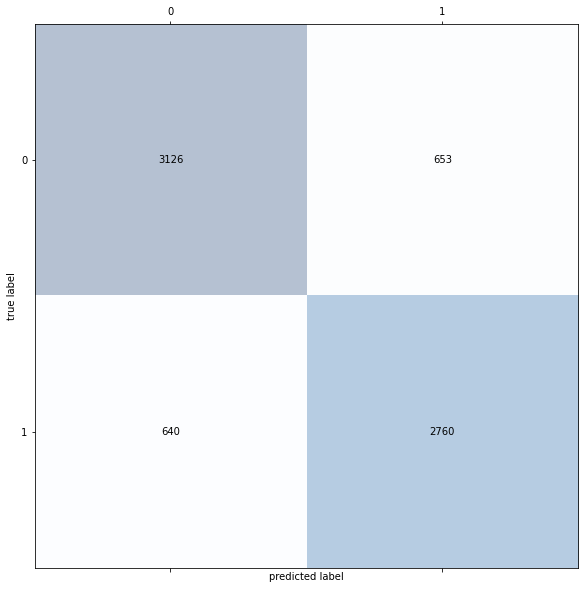

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

The model correctly classified 3126 of the samples that belong to class 0 (TNs) and 2760 samples that belong to class 1 (TPs), respectively. 

The model misclassified 640 cases as class 0 (FN), and it predicted 653 samples as FP.

### Validation curves

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:, ast.literal_eval(final_model.iloc[0,3])], y, test_size=0.33, random_state=rand)

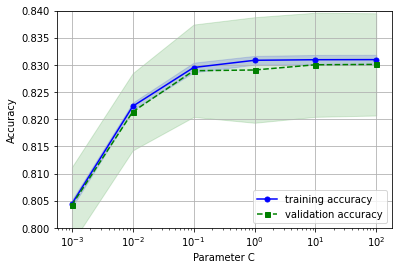

In [ ]:
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, .84])
plt.show()

On a above chart there is confirmation of notice which was made during hyperparameter tuning that the model performs better with high values of parameter C (low level of regularization).

The curve does not differ significantly for trainig and validation accuracy, so
the model is not overfitted (despite of the high number of variables)

### Independent variables p-value check

Once again the number of variables in model were checked.
This time model were trained in different api just to check p-values to make sure that all of dependent vairables are needed.
Almost all of them have p-value lower than 0,05, so it confirms previous feature selection results, therefore the model will not be changed further.   

In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Optimization terminated successfully.
         Current function value: 0.270708
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.609     
Dependent Variable: if_pos_review    AIC:              11878.8914
Date:               2022-07-25 10:29 BIC:              12286.2519
No. Observations:   21752            Log-Likelihood:   -5888.4   
Df Model:           50               LL-Null:          -15059.   
Df Residuals:       21701            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Unnamed: 0       -0.0002   0.0000 -55.1863 0.0000 -0.0002 -0.0002
worst            -1.0723   0.1116  -9.6059 0.0000 -1.2911 -0.8535


### Feature importance

The 5 most important features in predicting positive review were variables wonderfully, noir, excellent, perfect and perfectly.

The most important features in predicting negative review were variables: waste, worst, pointless, poorly, redeeming.

In [ ]:
pd.read_csv("feat_imp_LR1.csv")

,Unnamed: 0,name,int_feat_imp,permu_imp
0,0,worst,-1.817806,0.023123
1,1,waste,-2.294272,0.014469
2,2,awful,-1.684148,0.012066
3,3,poorly,-1.778705,0.005903
4,4,excellent,1.539385,0.012049
5,5,dull,-1.321633,0.003953
6,6,boring,-1.132592,0.004440
7,7,perfect,1.459019,0.005276
8,8,disappointment,-1.355376,0.003430
9,9,mess,-1.330923,0.003656


#Summary


A few classification models with features selected with different methods were trained.
The most promising one was logistic regression, so hyperparameters for this model were tuned.
Next model's performance and interpretation was made.